In [ ]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable


import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/pc5520/figures/basal_melt_param/'

In [ ]:
client = Client()
client

<Client: 'tcp://127.0.0.1:42877' processes=6 threads=24, memory=128.00 GiB>

In [ ]:
session_name = '/g/data/v45/wf4500/databases/gdata_01deg_jra55v13_ryf9091_DSW.db'
master_session = cc.database.create_session(session_name)
control = '01deg_jra55v13_ryf9091_DSW'

In [ ]:
basal_gade_woa = 'accessom2-GPC023'

icb_gade_woa = 'accessom2-GPC026'

start_time='1900-01-01'
end_time='1901-01-01'

lat_slice  = slice(-80,-59)

depthlim = 1500

In [ ]:
# build database for these experiments:
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

dir_list = ['/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC023/accessom2-GPC023/',
           '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC026/accessom2-GPC026/']

cc.database.build_index(dir_list,basal_melt_session)

Indexing experiment: accessom2-GPC023


0it [00:00, ?it/s]


Indexing experiment: accessom2-GPC026


0it [00:00, ?it/s]


0

In [ ]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=15

In [ ]:
# First plot map of bottom temperature to see where we want to plot transects

In [ ]:
start_time='1909-01-01'
end_time='1910-01-01'

salt_con = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_con = salt_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
salt_con = salt_con.mean('time')

salt_basal_gade = cc.querying.getvar(basal_gade_woa, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_basal_gade = salt_basal_gade.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
salt_basal_gade = salt_basal_gade.mean('time')

In [ ]:
# select out bottom values:
depth_array = salt_con * 0 + salt_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_salt_con = salt_con.where(depth_array.st_ocean >= max_depth)
bottom_salt_con = bottom_salt_con.sum(dim = 'st_ocean')
bottom_salt_con = bottom_salt_con.load()

bottom_salt_basal_gade = salt_basal_gade.where(depth_array.st_ocean >= max_depth)
bottom_salt_basal_gade = bottom_salt_basal_gade.sum(dim = 'st_ocean')
bottom_salt_basal_gade = bottom_salt_basal_gade.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice 

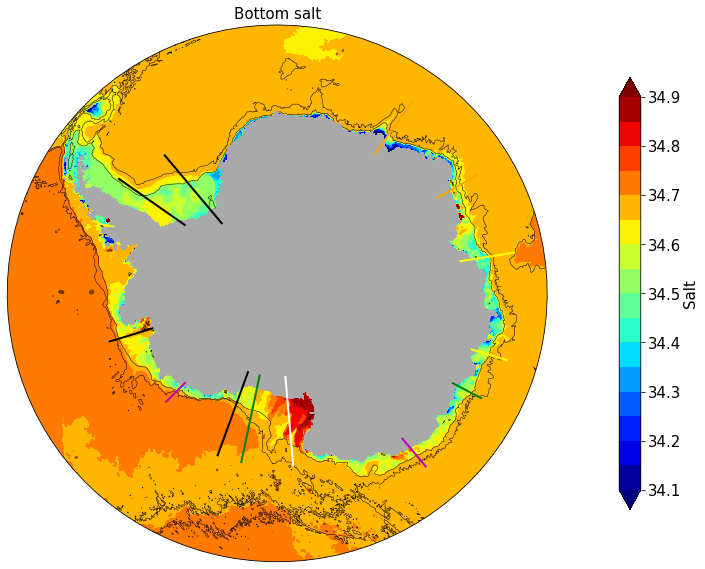

In [12]:
fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=34.1,vmax=34.9)
levels=np.arange(34.1,34.905,.05)
ticks = [34.3,34.4,34.5,34.6,34.7,34.8]

# up:
# setup stereo projection:
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.contourf(bottom_salt_con.xt_ocean, bottom_salt_con.yt_ocean, bottom_salt_basal_gade, norm = norm, levels=levels,
                   cmap = cmocean.cm.jet, extend='both',transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Bottom salt',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())

# Add transect lines:

#Ross1
plt.plot([-185,-185],[-80,-70],'white',linewidth=2,transform = ccrs.PlateCarree())
#Ross2
plt.plot([-168,-168],[-80,-70],'green',linewidth=2,transform = ccrs.PlateCarree())
#Ross3
plt.plot([-160,-160],[-80,-70],'k',linewidth=2,transform = ccrs.PlateCarree())
#WedellW
plt.plot([-55,-55],[-77,-68],'k',linewidth=2,transform = ccrs.PlateCarree())
#WedellE
plt.plot([-40,-40],[-80,-70],'k',linewidth=2,transform = ccrs.PlateCarree())
# AmundsenE:
plt.plot([-107,-107],[-75,-70],'k',linewidth=2,transform = ccrs.PlateCarree())
# AmundsenW:
plt.plot([-135,-135],[-75,-72],'m',linewidth=2,transform = ccrs.PlateCarree())
# warm patch just downstream of Mertz:
plt.plot([-220,-220],[-68,-64],'m',linewidth=2,transform = ccrs.PlateCarree())
# cooling in Totten:
plt.plot([-242,-242],[-67.5,-64],'green',linewidth=2,transform = ccrs.PlateCarree())
# cold patch in Vincennes Bay:
plt.plot([-253,-253],[-67,-63],'yellow',linewidth=2,transform = ccrs.PlateCarree())
# Inter I:
plt.plot([-279,-279],[-69,-63],'yellow',linewidth=2,transform = ccrs.PlateCarree())
# warm patch downstream of PrydzE:
plt.plot([60,60],[-69,-64],'orange',linewidth=2,transform = ccrs.PlateCarree())
# warm patch downstream of PrydzW:
plt.plot([35.5,35.5],[-71,-64],'orange',linewidth=2,transform = ccrs.PlateCarree())
        
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.65, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Salt',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

#figure_path = figdir+'map_bottom_salt_with_transect_locations.png'
#plt.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1,facecolor='white')

In [11]:
#Temperature transects

In [13]:
zlevel1 = 0
zlevel2 = depthlim + 100

def get_transect_extra_data(lon,lat1,lat2,extrasim,month1,month2,year1,year2):
    lat_slice  = slice(lat1, lat2)
    
    first_year = str(year1)
    last_year = str(year2)
    
    start_time=first_year+'-'+f'{month1:02}'+'-01'
    end_time=last_year+'-'+f'{month2:02}'+'-01'

    # import bathymetry:
    ht_transect = cc.querying.getvar(control,'ht',master_session,n=1)
    ht_transect = ht_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice)
    ht_transect = ht_transect.load()
    ht_transect[np.isnan(ht_transect)] = 0
    
    temp_extra_transect = cc.querying.getvar(extrasim, 'temp', basal_melt_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
    temp_extra_transect = temp_extra_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    temp_extra_transect = temp_extra_transect.load()
    
    salt_extra_transect = cc.querying.getvar(extrasim, 'salt', basal_melt_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    salt_extra_transect = salt_extra_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    salt_extra_transect = salt_extra_transect.load()
    
    age_extra_transect = cc.querying.getvar(extrasim, 'age_global', basal_melt_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    age_extra_transect = age_extra_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    age_extra_transect = age_extra_transect.load()
    
    v_extra_transect = cc.querying.getvar(extrasim, 'v', basal_melt_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    v_extra_transect = v_extra_transect.sel(xu_ocean=lon,method='nearest').sel(yu_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    v_extra_transect = v_extra_transect.load()
    
    rho0_extra = cc.querying.getvar(extrasim, 'pot_rho_0', basal_melt_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    rho0_extra = rho0_extra.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    rho0_extra = rho0_extra.load()
    
    #Import basal melt
    #basal_basal_gade = cc.querying.getvar(extrasim, 'basal_fwflx', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
    #basal_basal_gade = basal_basal_gade.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    #basal_basal_gade = basal_basal_gade.load()
    
    return ht_transect,temp_extra_transect,salt_extra_transect,age_extra_transect,v_extra_transect,rho0_extra

In [14]:
zlevel1 = 0
zlevel2 = depthlim + 100

def get_transect_data(lon,lat1,lat2,month1,month2,year1,year2):
    lat_slice  = slice(lat1, lat2) 
    
    first_year = str(year1)
    last_year = str(year2)

    start_time=first_year+'-'+f'{month1:02}'+'-01'
    end_time=last_year+'-'+f'{month2:02}'+'-01'

    # import bathymetry:
    ht_transect = cc.querying.getvar(control,'ht',master_session,n=1)
    ht_transect = ht_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice)
    ht_transect = ht_transect.load()
    ht_transect[np.isnan(ht_transect)] = 0

    ### load data for this period:
    temp_con_transect = cc.querying.getvar(control,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
    temp_con_transect = temp_con_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    temp_con_transect = temp_con_transect.load()

    ### load data for this period:
    salt_con_transect = cc.querying.getvar(control,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    salt_con_transect = salt_con_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    salt_con_transect = salt_con_transect.load()
    
    ### load data for this period:
    age_con_transect = cc.querying.getvar(control,'age_global' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    age_con_transect = age_con_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    age_con_transect = age_con_transect.load()

    ### load data for this period:
    v_con_transect = cc.querying.getvar(control,'v' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    v_con_transect = v_con_transect.sel(xu_ocean=lon,method='nearest').sel(yu_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    v_con_transect = v_con_transect.load()
    
    ### also get density for plotting isopycnals:
    rho0_con = cc.querying.getvar(control,'pot_rho_0' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    rho0_con = rho0_con.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2)).mean('time')
    rho0_con = rho0_con.load()
    
    return ht_transect,temp_con_transect,salt_con_transect,age_con_transect,v_con_transect,rho0_con


In [15]:
def plot_transects(region,config,config2, month1,month2,year1,year2):

    if region == 'AmundsenW':
        lon = -135
        lat1 = -74.7
        lat2 = -73
    elif region == 'AmundsenW2':
        lon = -147
        lat1 = -78
        lat2 = -72
    elif region == 'AmundsenE':
        lon = -107
        lat1 = -75
        lat2 = -70
    elif region == 'Mertz':
        lon = -220
        lat1 = -66.8
        lat2 = -64.5
    elif region == 'Totten':
        lon = -242
        lat1 = -67.2
        lat2 = -64
    elif region == 'Vincennes':
        lon = -253
        lat1 = -67
        lat2 = -63
    elif region == 'Interm':
        lon = -279
        lat1 = -69
        lat2 = -63
    elif region == 'PrydzE':
        lon = 60
        lat1 = -67.5
        lat2 = -64    
    elif region == 'PrydzW':
        lon = 35.5
        lat1 = -69.5
        lat2 = -66 
    elif region == 'WedellW':
        lon = -55
        lat1 = -77
        lat2 = -68
    elif region == 'WedellE':
        lon = -40
        lat1 = -80
        lat2 = -70
    elif region == 'Ross1':
        lon = -185
        lat1 = -80
        lat2 = -70
    elif region == 'Ross2':
        lon = -168
        lat1 = -80
        lat2 = -70
    elif region == 'Ross3':
        lon = -160
        lat1 = -80
        lat2 = -70

    ht_transect,temp_con_transect,salt_con_transect,age_con_transect,v_con_transect,rho0_con = get_transect_data(lon,lat1,lat2+.1,month1,month2,year1,year2)
    
    extrasim = config #basal
    ht_transect2,temp_extra_transect,salt_extra_transect,age_extra_transect,v_extra_transect,rho0_extra = get_transect_extra_data(lon,lat1,lat2+.1,extrasim,month1,month2,year1,year2)
    
    extrasim2 = config2 #icb
    ht_transect3,temp_extra_transect2,salt_extra_transect2,age_extra_transect2,v_extra_transect2,rho0_extra2 = get_transect_extra_data(lon,lat1,lat2+.1,extrasim2,month1,month2,year1,year2)
    

    ####
    
    
    ylimit = depthlim
    
    fontsize=16

    fig=plt.figure(figsize=(20,32))

    scale_max = 0.4

    density_contours = [1027.5,1027.6,1027.72,1027.78,1027.81,1027.83,1027.835,1027.84,1027.845,1027.85]
    
    #####################################################################################################

    #### Control ####
    plt.subplot(4,3,1)
    norm = col.Normalize(vmin=-3,vmax=2)
    levels=np.arange(-3,2.05,.05)
    ticks = [-3,-2,-1,0,1,2]

    pcm = plt.contourf(temp_con_transect.yt_ocean,temp_con_transect.st_ocean,
                       temp_con_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.cm.jet, norm = norm,levels=levels,extend='both')
    plt.fill_between(temp_con_transect.yt_ocean,ht_transect,ylimit,zorder=3,color='darkgrey')
    plt.ylim(ylimit,0)
    plt.xlim(lat1,lat2)
    plt.ylabel('Depth (m)',fontsize=fontsize)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    
    plt.title('Control',fontsize=fontsize)


    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Temperature ($^\circ$C)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)
    
    #### Basal Gade - con ####
    plt.subplot(4,3,2)
    norm = col.Normalize(vmin=-3,vmax=2)
    levels=np.arange(-3,2.05,.05)
    ticks = [-3,-2,-1,0,1,2]

    pcm = plt.contourf(temp_con_transect.yt_ocean,temp_con_transect.st_ocean,
                       temp_extra_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.cm.jet, norm = norm,levels=levels,extend='both')
    plt.fill_between(temp_extra_transect.yt_ocean,ht_transect,ylimit,zorder=3,color='darkgrey')
    plt.ylim(ylimit,0)
    plt.xlim(lat1,lat2)
    plt.ylabel('Depth (m)',fontsize=fontsize)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_extra,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    
    plt.title('Basal_Gade',fontsize=fontsize)


    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Temperature($^\circ$C)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)


    #### icb - con ####
    plt.subplot(4,3,3)
    norm = col.Normalize(vmin=-3,vmax=2)
    levels=np.arange(-3,2.05,.05)
    ticks = [-3,-2,-1,0,1,2]
    
    pcm = plt.contourf(temp_con_transect.yt_ocean,temp_con_transect.st_ocean,
                       (temp_extra_transect2.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')),
                       cmap = cmocean.cm.jet, norm = norm,levels=levels,extend='both')
    plt.fill_between(temp_extra_transect2.yt_ocean,ht_transect,ylimit,zorder=3,color='darkgrey')
    plt.ylim(ylimit,0)
    plt.xlim(lat1,lat2)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_extra2,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)

    #plt.title(region+', longitude='+str(lon),fontsize=fontsize)
    plt.title('ICB',fontsize=fontsize)
    
    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Temperature ($^\circ$C)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)
    
    #####################################################################################################
    
    #### Control salt:
    plt.subplot(4,3,4)
    norm = col.Normalize(vmin=33,vmax=35)
    levels=np.arange(33,35,.1)
    ticks = [33,33.5,34,34.5,35]

    pcm = plt.contourf(salt_con_transect.yt_ocean,salt_con_transect.st_ocean,
                       salt_con_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.cm.jet, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,ylimit,zorder=3,color='darkgrey')
    plt.ylim(ylimit,0)
    plt.xlim(lat1,lat2)
    plt.ylabel('Depth (m)',fontsize=fontsize)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    plt.title('Control',fontsize=fontsize)

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Salt',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)
    
    #### Basal diff:
    plt.subplot(4,3,5)
    norm = col.Normalize(vmin=33,vmax=35)
    levels=np.arange(33,35,.1)
    ticks = [33,33.5,34,34.5,35]

    pcm = plt.contourf(salt_con_transect.yt_ocean,salt_con_transect.st_ocean,
                       (salt_extra_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')),
                       cmap = cmocean.cm.jet, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,ylimit,zorder=3,color='darkgrey')
    plt.ylim(ylimit,0)
    plt.xlim(lat1,lat2)
    plt.ylabel('Depth (m)',fontsize=fontsize)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_extra,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    plt.title('Basal_Gade',fontsize=fontsize)

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Salt',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)


    #### ICB diff:
    plt.subplot(4,3,6)
    norm = col.Normalize(vmin=33,vmax=35)
    levels=np.arange(33,35,.1)
    ticks = [33,33.5,34,34.5,35]
    
    pcm = plt.contourf(salt_con_transect.yt_ocean,salt_con_transect.st_ocean,
                       (salt_extra_transect2.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')),
                       cmap = cmocean.cm.jet, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,ylimit,zorder=3,color='darkgrey')
    plt.ylim(ylimit,0)
    plt.xlim(lat1,lat2)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_extra2,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    
    plt.title('ICB',fontsize=fontsize)


    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Salt',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)
    
    #####################################################################################################
    
    #### Control age:
    plt.subplot(4,3,7)
    norm = col.Normalize(vmin=0,vmax=2)
    levels=np.arange(0,2,.1)
    ticks = [0,0.5,1,1.5,2]

    pcm = plt.contourf(age_con_transect.yt_ocean,age_con_transect.st_ocean,
                       age_con_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.cm.jet, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,ylimit,zorder=3,color='darkgrey')
    plt.ylim(ylimit,0)
    plt.xlim(lat1,lat2)
    plt.ylabel('Depth (m)',fontsize=fontsize)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    plt.title('Control',fontsize=fontsize)

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Age (yr)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)
    
    #### Basal_Gade diff:
    plt.subplot(4,3,8)
    norm = col.Normalize(vmin=0,vmax=2)
    levels=np.arange(0,2,.1)
    ticks = [0,0.5,1,1.5,2]

    pcm = plt.contourf(age_con_transect.yt_ocean,age_con_transect.st_ocean,
                       (age_extra_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')),
                       cmap = cmocean.cm.jet, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,ylimit,zorder=3,color='darkgrey')
    plt.ylim(ylimit,0)
    plt.xlim(lat1,lat2)
    plt.ylabel('Depth (m)',fontsize=fontsize)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_extra,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    plt.title('Basal_Gade',fontsize=fontsize)

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Age (yr)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)


    #### Basal_gade age:
    plt.subplot(4,3,9)
    norm = col.Normalize(vmin=0,vmax=2)
    levels=np.arange(0,2,.1)
    ticks = [0,0.5,1,1.5,2]
    pcm = plt.contourf(age_con_transect.yt_ocean,age_con_transect.st_ocean,
                       (age_extra_transect2.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')),
                       cmap = cmocean.cm.jet, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,ylimit,zorder=3,color='darkgrey')
    plt.ylim(ylimit,0)
    plt.xlim(lat1,lat2)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_extra2,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    
    plt.title('ICB',fontsize=fontsize)
    # basal
    #cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,basal_Tfreezing_min,
    #                  colors='pink',zorder=2 ,linewidths=10)

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Age (yr)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)
    
    #####################################################################################################
    
    #### Control v:
    plt.subplot(4,3,10)
    norm = col.Normalize(vmin=-0.1,vmax=0.1)
    levels=np.arange(-0.1,0.1,0.01)
    ticks = [-0.1,-0.05,0,0.05,0.1]

    pcm = plt.contourf(v_con_transect.yu_ocean,v_con_transect.st_ocean,
                       v_con_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.cm.jet, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,ylimit,zorder=3,color='darkgrey')
    plt.ylim(ylimit,0)
    plt.xlim(lat1,lat2)
    plt.ylabel('Depth (m)',fontsize=fontsize)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Control v',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)
    
    #### Basal Gade diff:
    plt.subplot(4,3,11)
    norm = col.Normalize(vmin=-0.1,vmax=0.1)
    levels=np.arange(-0.1,0.1,0.01)
    ticks = [-0.1,-0.05,0,0.05,0.1]

    pcm = plt.contourf(v_con_transect.yu_ocean,v_con_transect.st_ocean,
                       (v_extra_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')),
                       cmap = cmocean.cm.jet, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,ylimit,zorder=3,color='darkgrey')
    plt.ylim(ylimit,0)
    plt.xlim(lat1,lat2)
    plt.ylabel('Depth (m)',fontsize=fontsize)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_extra,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'v',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)


    #### Tfreezing_min age anomaly:
    plt.subplot(4,3,12)
    norm = col.Normalize(vmin=-0.1,vmax=0.1)
    levels=np.arange(-0.1,0.1,0.01)
    ticks = [-0.1,-0.05,0,0.05,0.1]
    pcm = plt.contourf(v_con_transect.yu_ocean,v_con_transect.st_ocean,
                       (v_extra_transect2.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')),
                       cmap = cmocean.cm.jet, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,ylimit,zorder=3,color='darkgrey')
    plt.ylim(ylimit,0)
    plt.xlim(lat1,lat2)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_extra2,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con,density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    # basal
    #cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,basal_Tfreezing_min,
    #                  colors='pink',zorder=2 ,linewidths=10)

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'v',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)


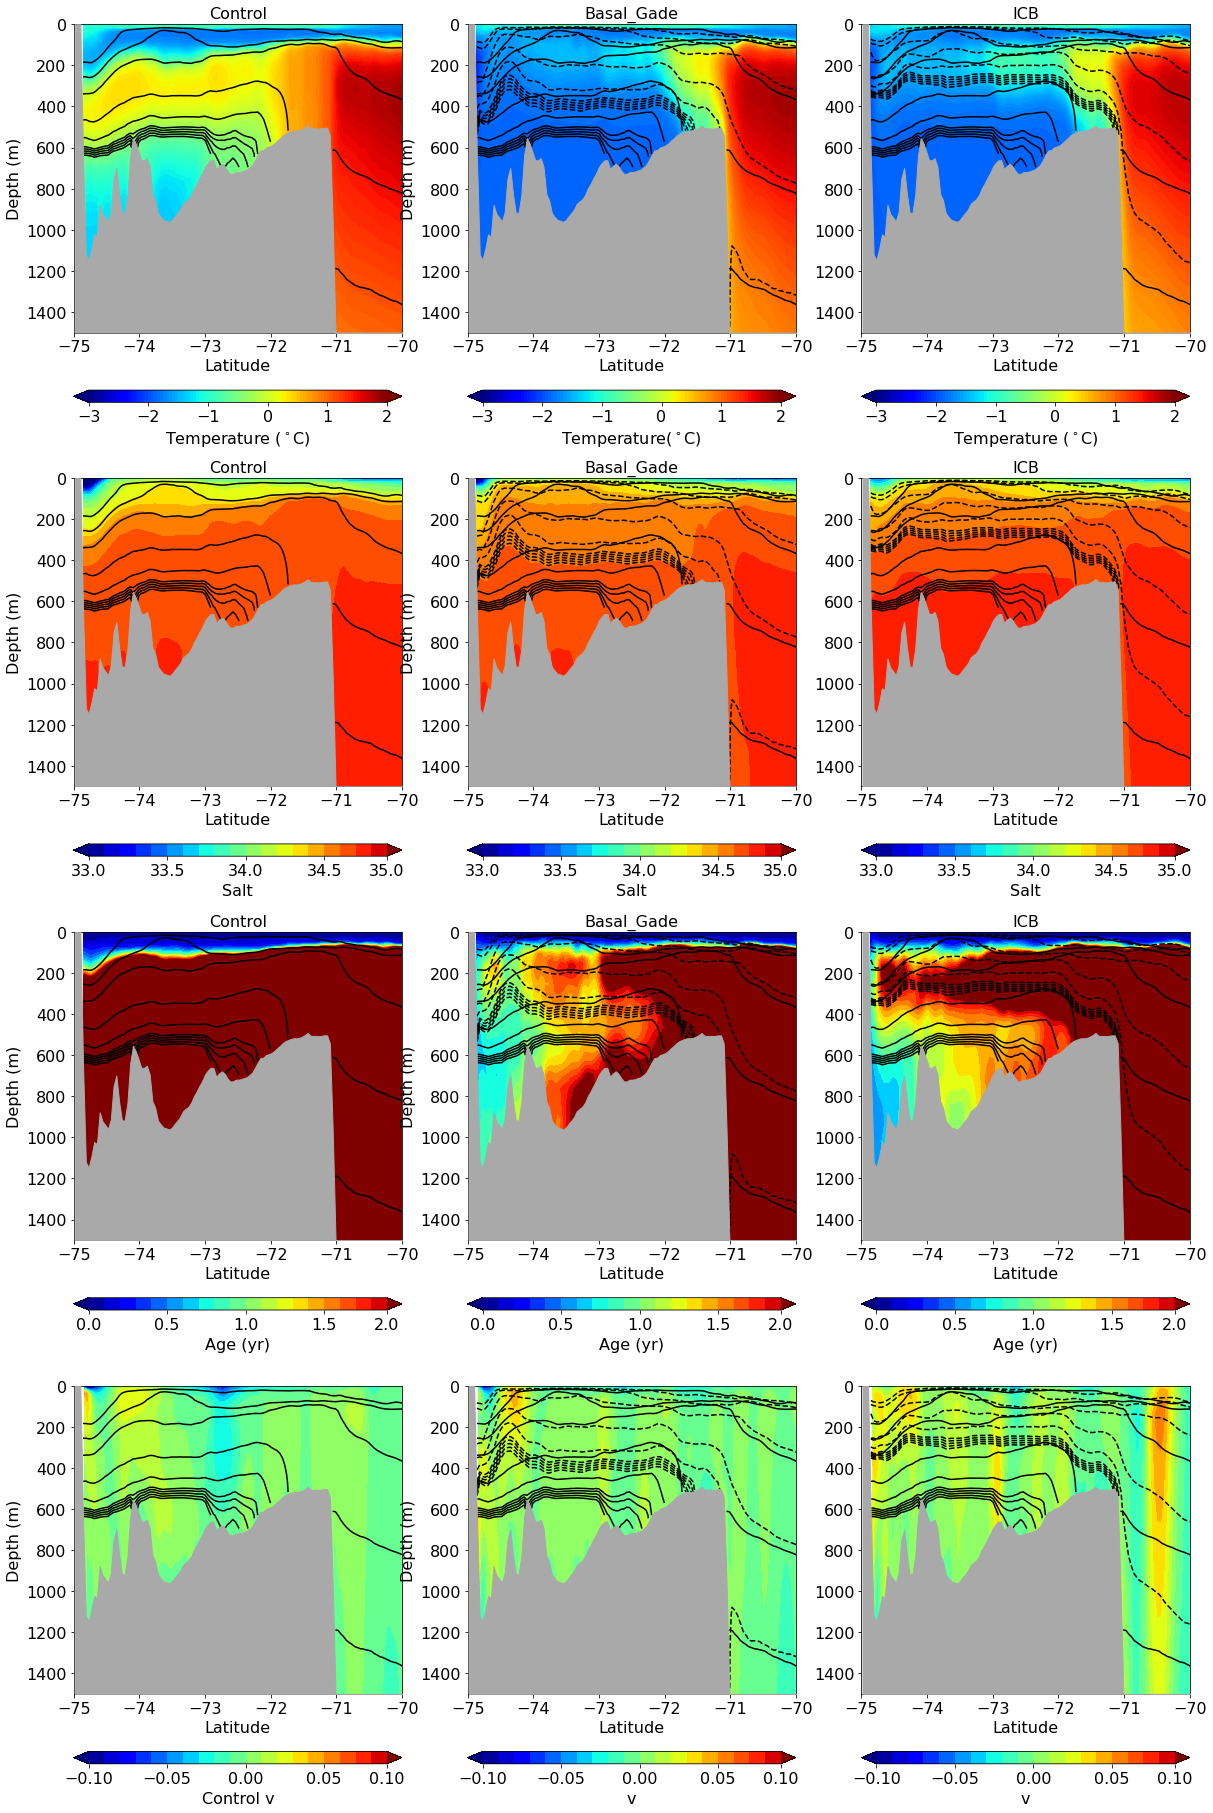

In [24]:
plot_transects('AmundsenE',basal_gade_woa,icb_gade_woa,1,1,1909,1910)

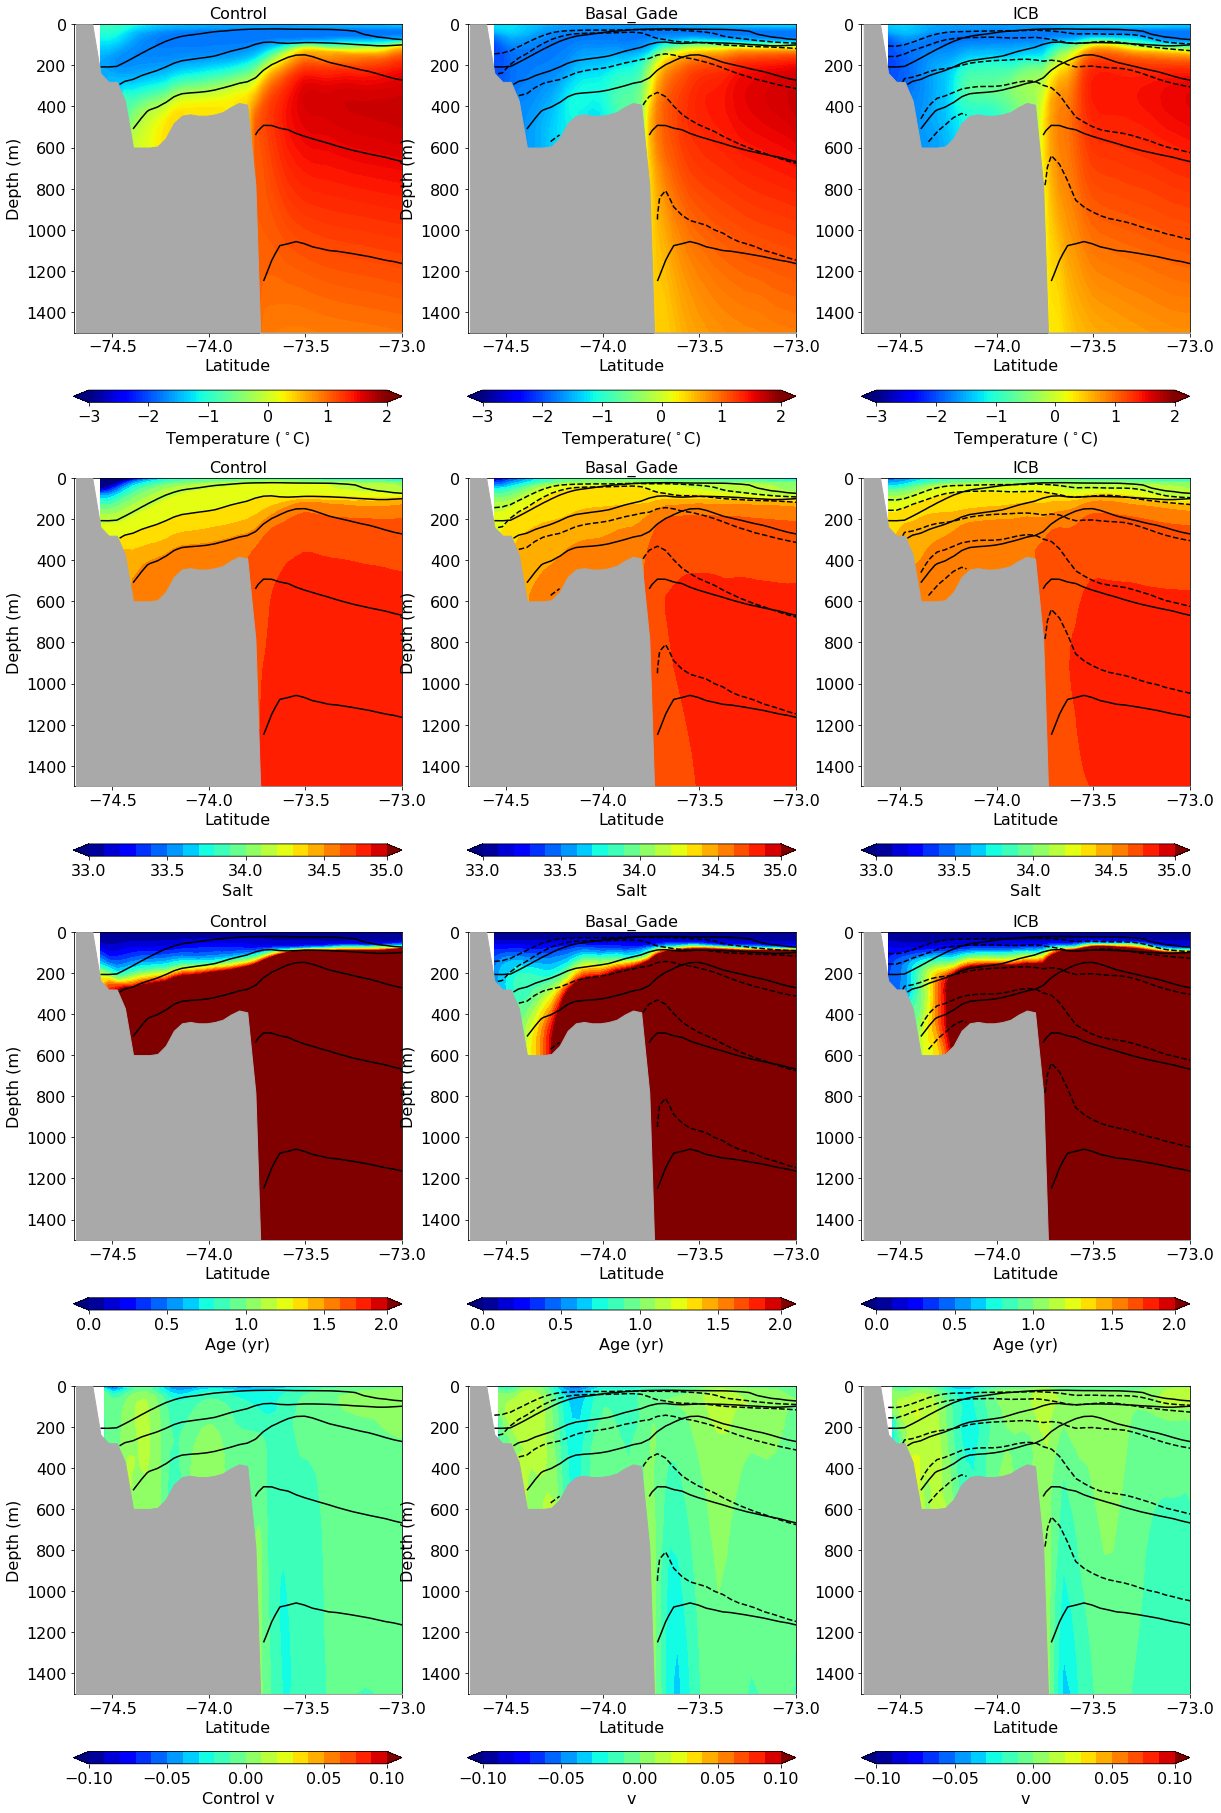

In [25]:
plot_transects('AmundsenW',basal_gade_woa,icb_gade_woa,1,1,1909,1910)

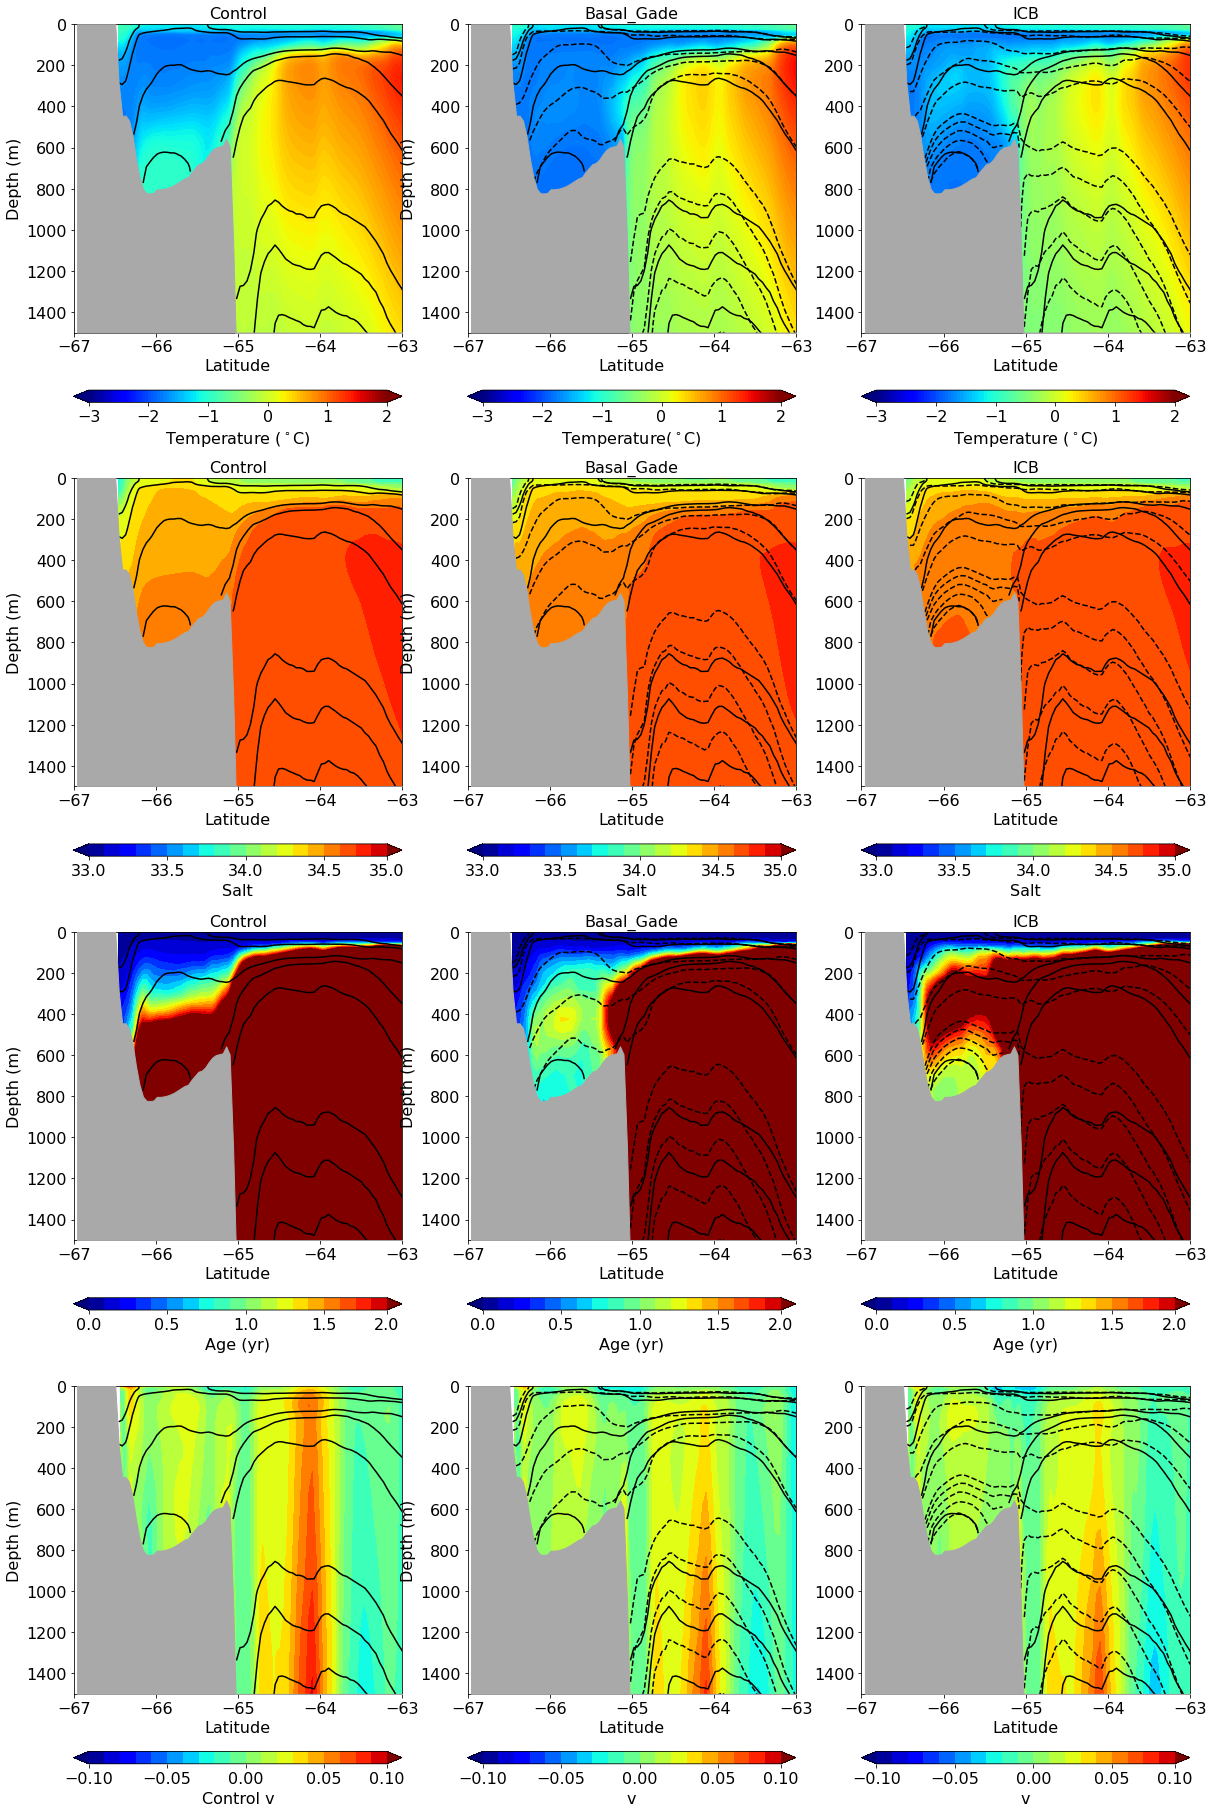

In [26]:
plot_transects('Vincennes',basal_gade_woa,icb_gade_woa,1,1,1909,1910)

2023-07-20 10:50:40,909 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2023-07-20 10:50:44,119 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-07-20 10:50:47,126 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-07-20 10:50:49,827 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-07-20 10:50:51,670 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


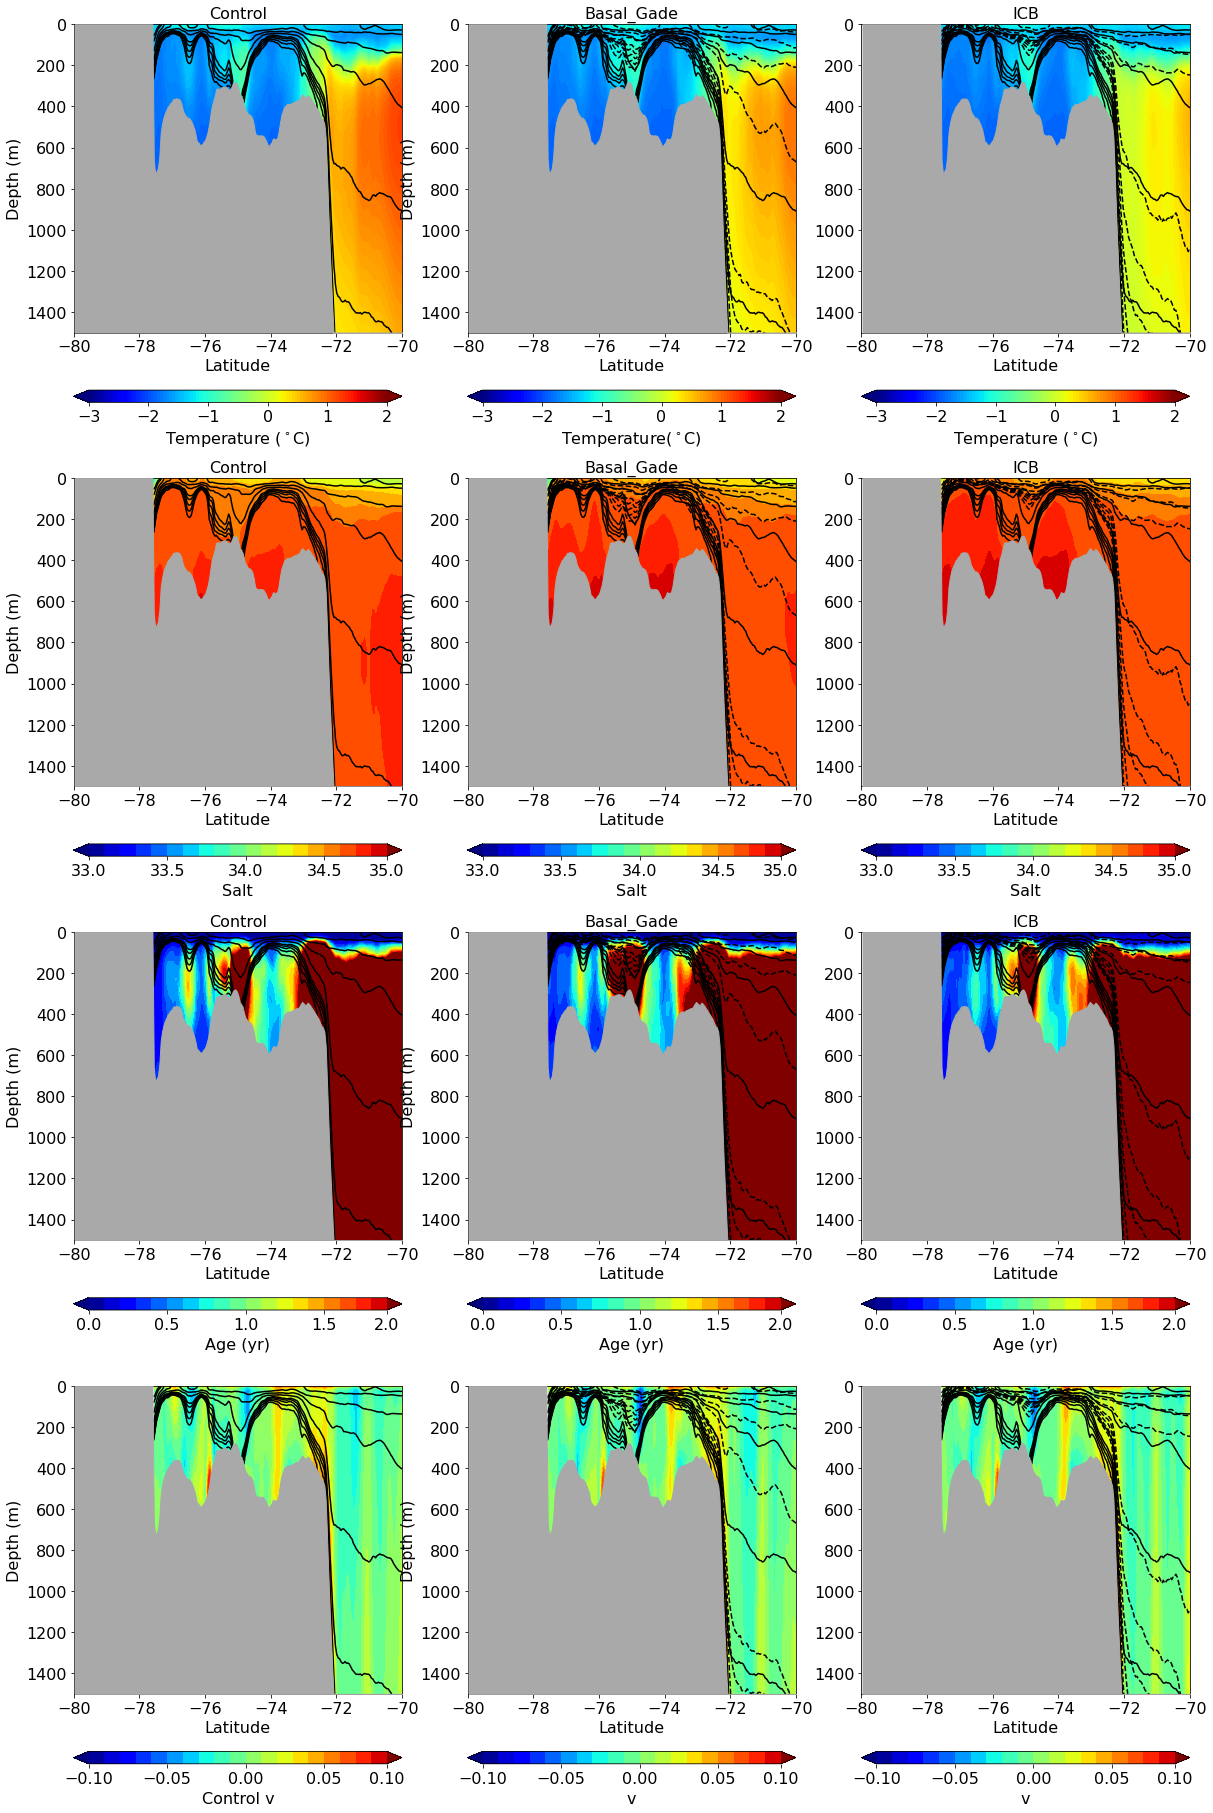

In [27]:
plot_transects('Ross1',basal_gade_woa,icb_gade_woa,1,1,1909,1910)

2023-07-20 10:50:55,873 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-07-20 10:50:57,108 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-07-20 10:50:59,331 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-07-20 10:51:00,851 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-07-20 10:51:03,744 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-07-20 10:51:06,659 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-07-20 10:51:09,815 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-07-20 10:51:11,359 - distributed.utils_perf - WARNING - full garbage collections took

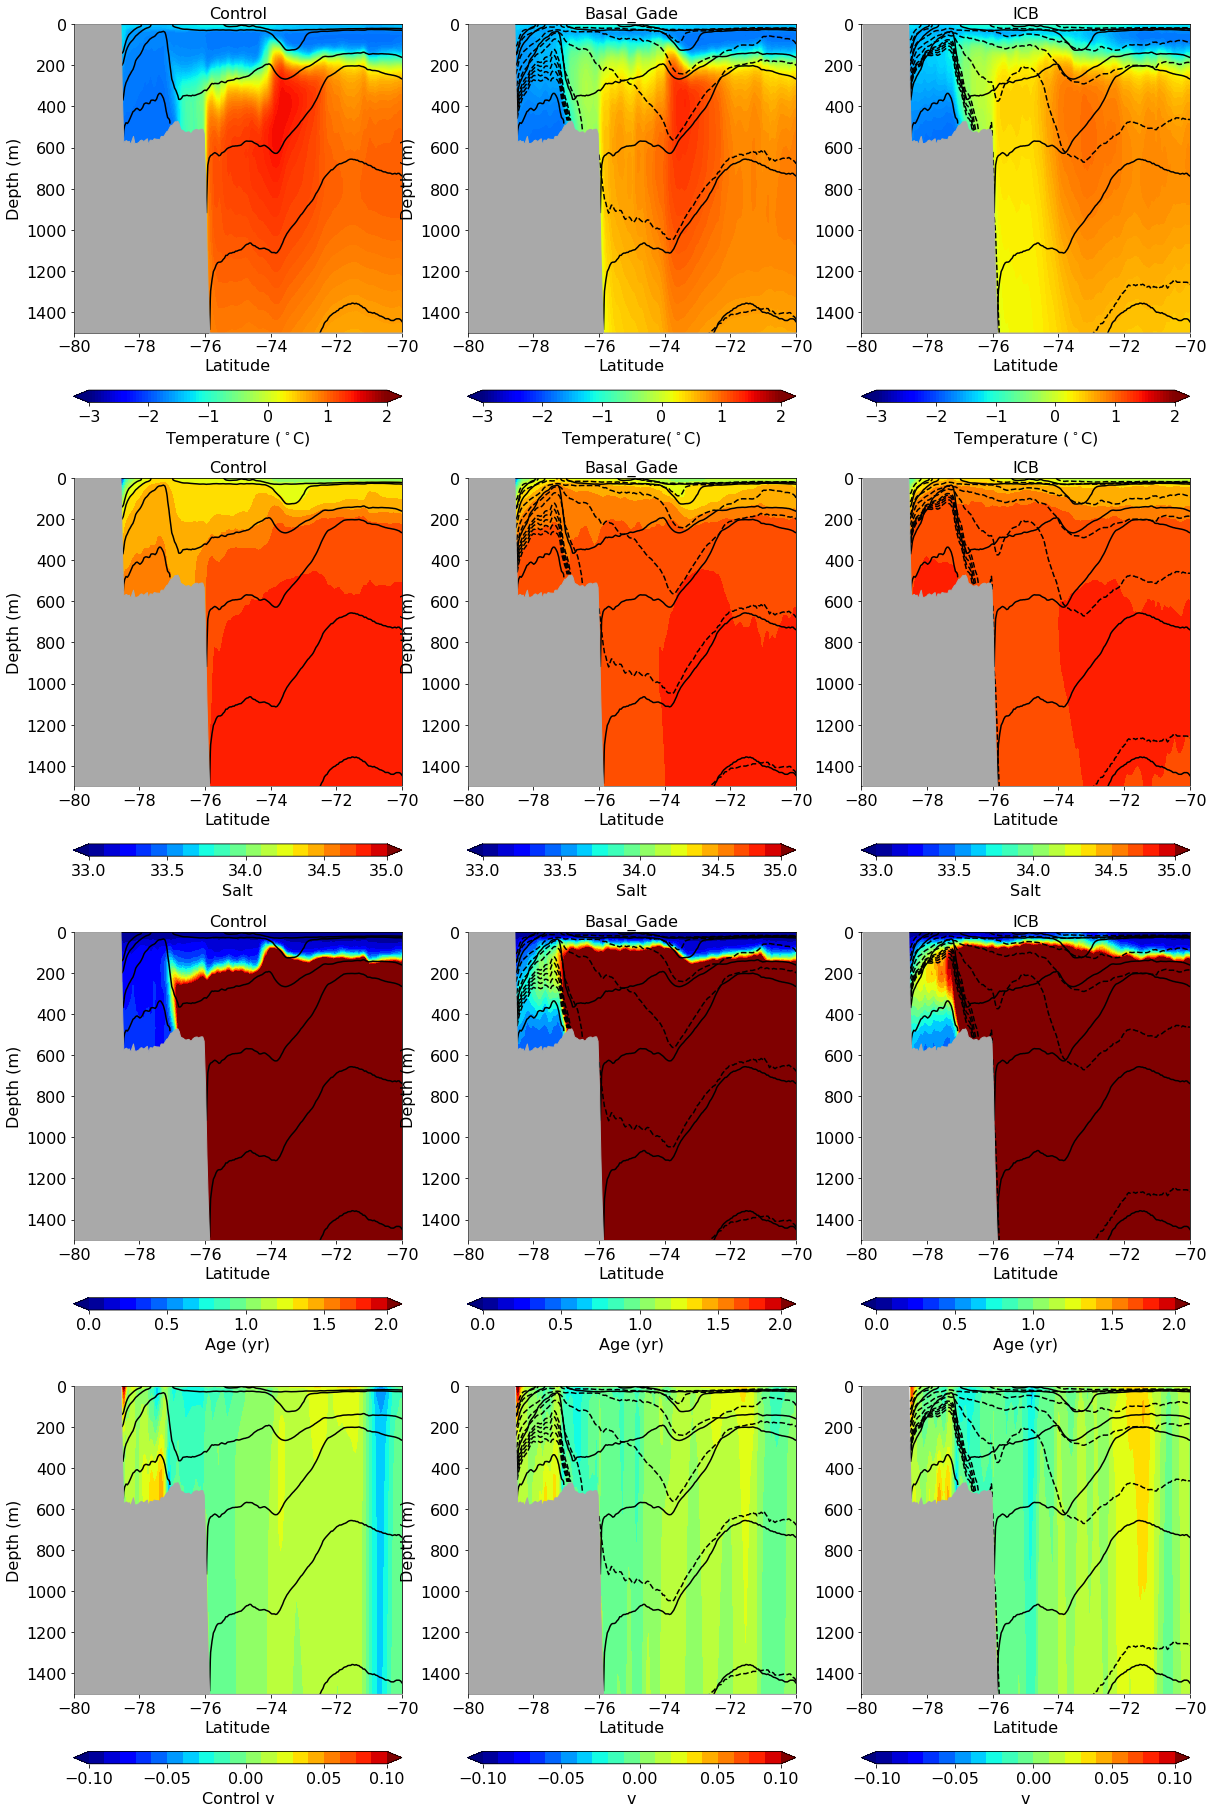

In [28]:
plot_transects('Ross2',basal_gade_woa,icb_gade_woa,1,1,1909,1910)

2023-07-20 10:51:19,969 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-07-20 10:51:21,813 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-07-20 10:51:23,026 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-07-20 10:51:25,483 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-07-20 10:51:27,901 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-07-20 10:51:29,425 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-07-20 10:51:33,002 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-07-20 10:51:35,550 - distributed.utils_perf - WARNING - full garbage collections took

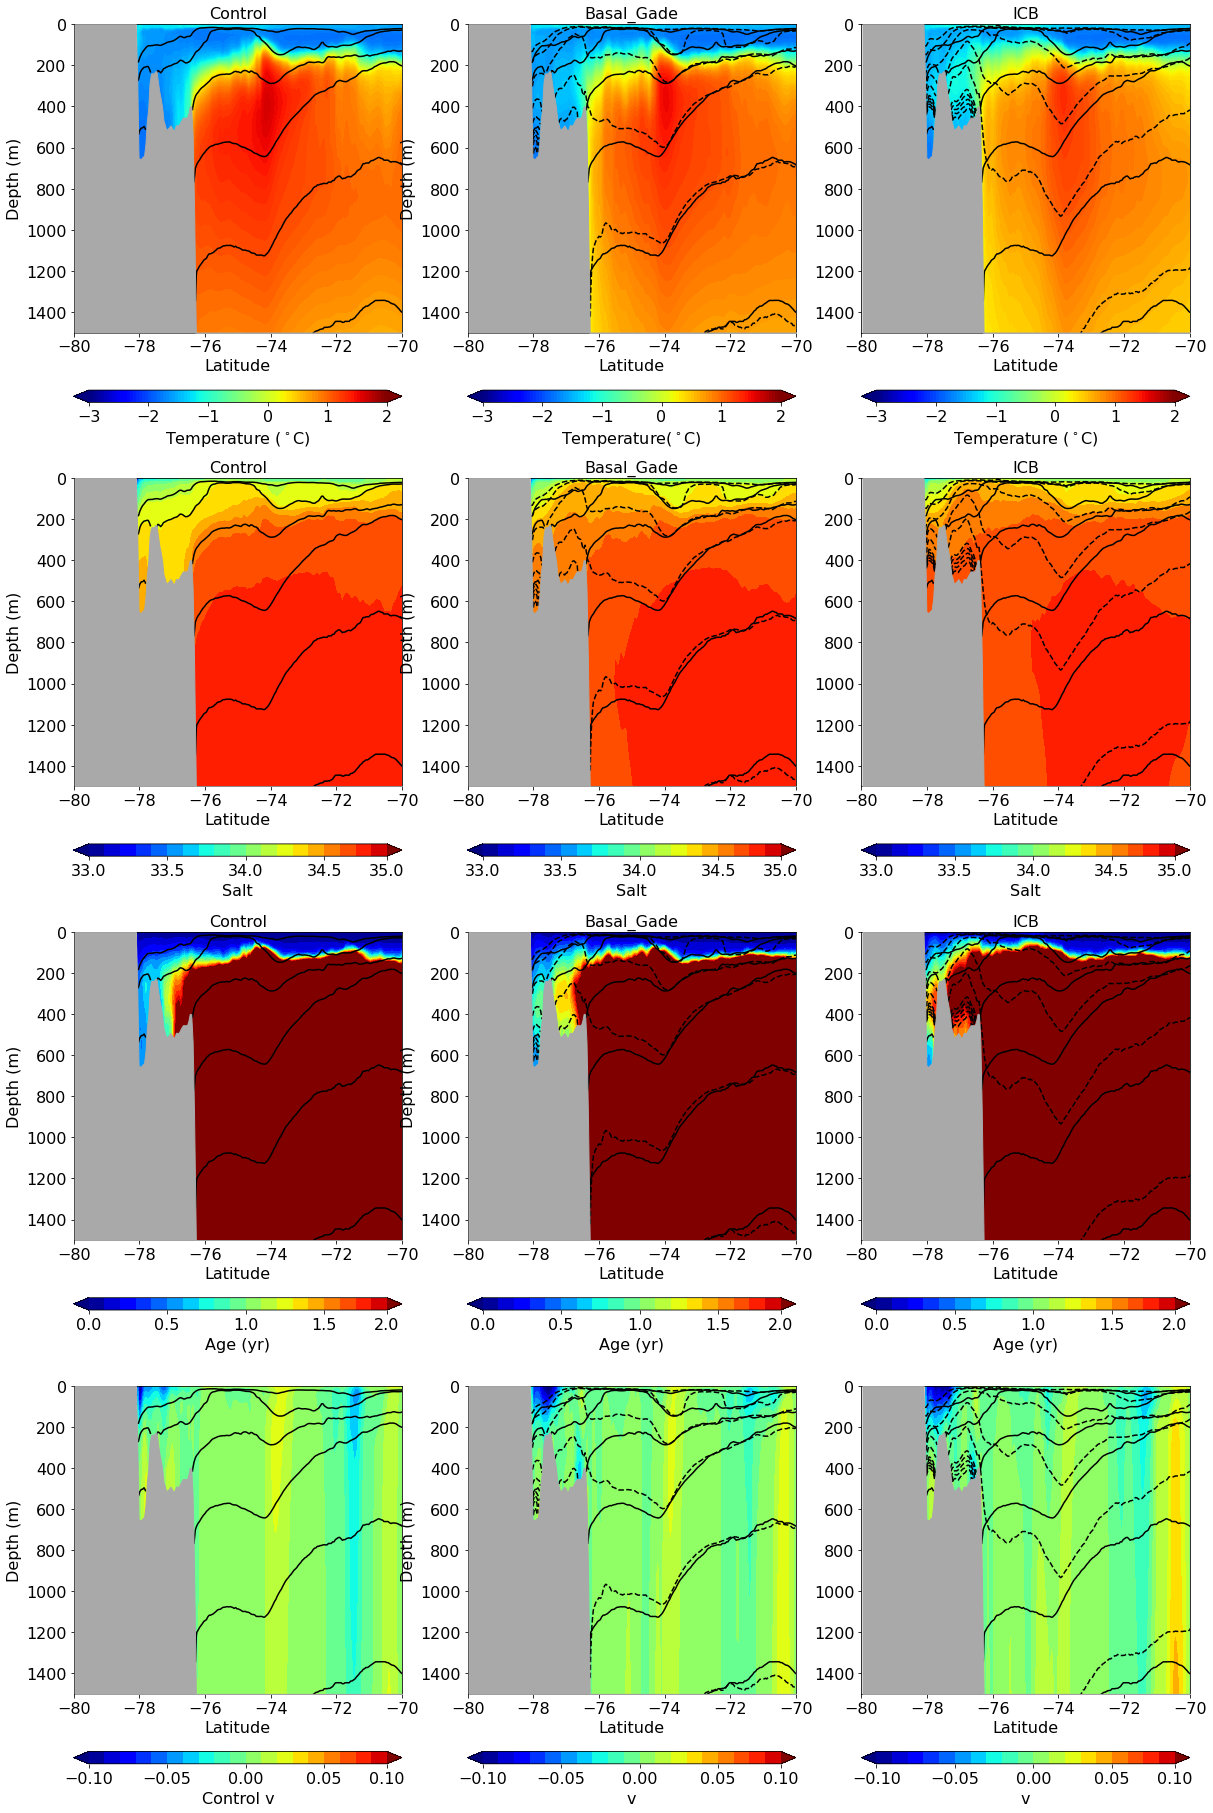

In [29]:
plot_transects('Ross3',basal_gade_woa,icb_gade_woa,1,1,1909,1910)

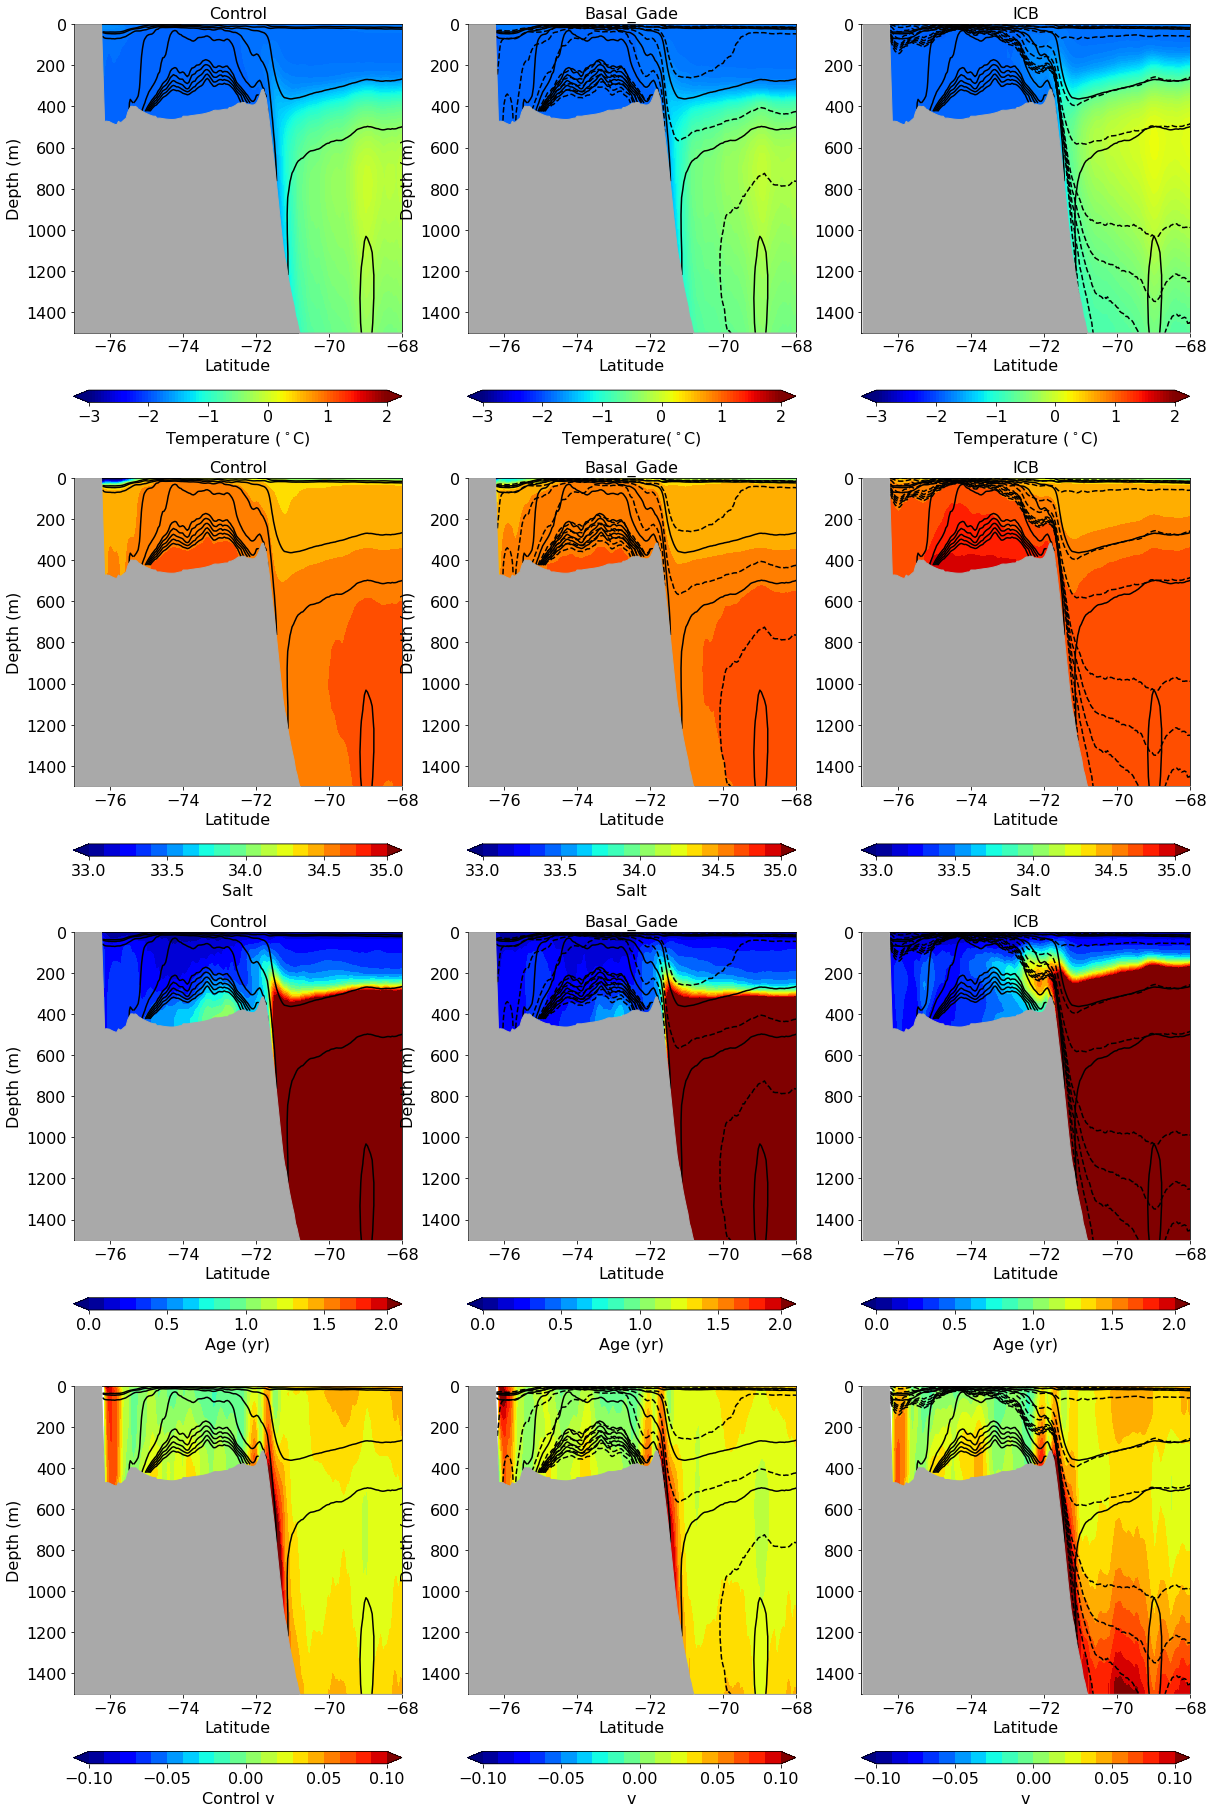

In [16]:
plot_transects('WedellW',basal_gade_woa,icb_gade_woa,1,1,1909,1910)